In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

# Closed Loop implemented as Neural ODE on a mesh

Initializing
Loaded mesh gradient operators
Using scipy solve_ivp
Done
(21, 1797)
(21, 1, 236, 200)


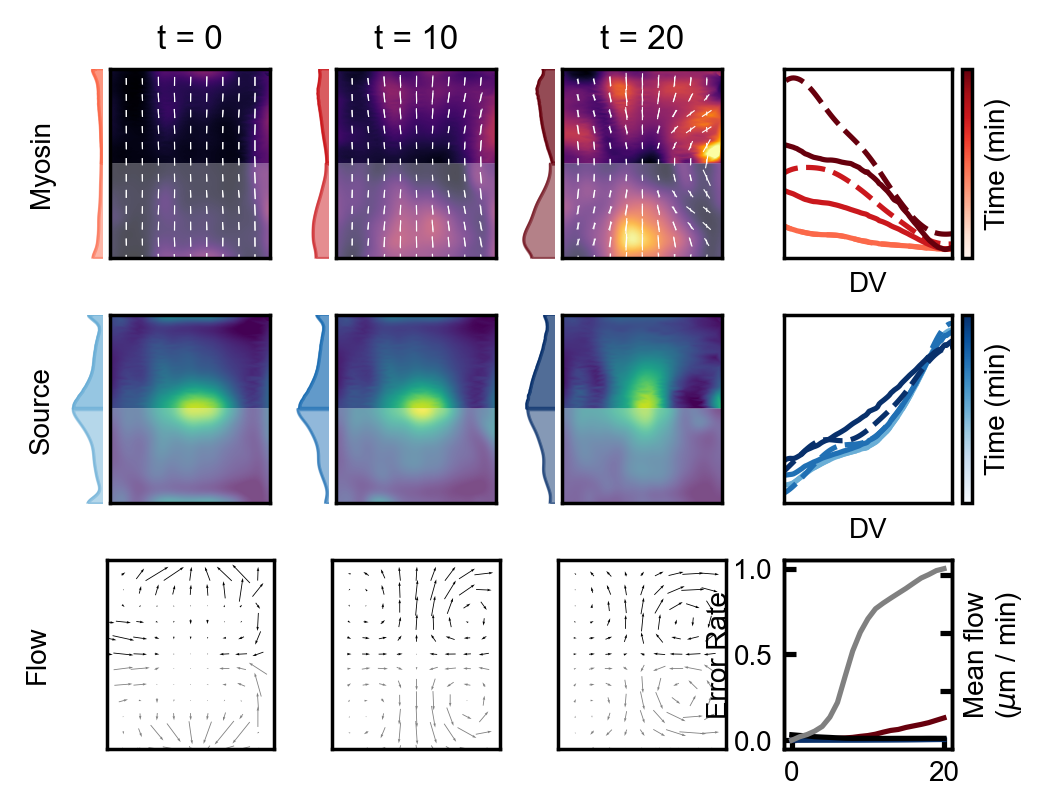

In [25]:
from scipy.interpolate import interp1d

from utils.geometry.closed_loop import ClosedLoopMesh
from utils.geometry.geometry_utils import MeshInterpolator
from utils.decomposition.decomposition_model import LeftRightSymmetrize
from utils.forecasting.plot_utils import *

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = 0, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    s0 = LeftRightSymmetrize().fit_transform(s0)
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]

#Using a flow field interpolator in the loop instead of a neural network
mesh_int = MeshInterpolator().fit(None)

v_verts = np.stack([
    mesh_int.transform(v0[i, ..., 10:-10]) for i in range(len(v0))
])
v_int = interp1d(t0, 
                 v_verts, 
                 axis=0, fill_value='extrapolate')
v_model = lambda t, y: v_int(t)

y0 = np.concatenate([
    mesh_int.transform(m0[0]).reshape([4, 1797]),
    mesh_int.transform(s0[0]).reshape([1, 1797])
])


model = ClosedLoopMesh(v_model=v_model, sigma=.5)
m, s, v = model.integrate(y0, t0)
print('Done')

print(s.shape)

m = np.stack([mesh_int.inverse_transform(m[i]) for i in range(len(m))])
s = np.stack([mesh_int.inverse_transform(s[i]) for i in range(len(s))])
v = np.stack([mesh_int.inverse_transform(v[i]) for i in range(len(v))])

print(s.shape)

#sqh_vel_plot(m, v, t0, dt=5)
comparison_plot(t0,
                ('Myosin', m, m0),
                ('Source', s, s0),
                ('Flow', v, v0),
                dt=10)

(21, 236, 200) (21, 1, 236, 200)


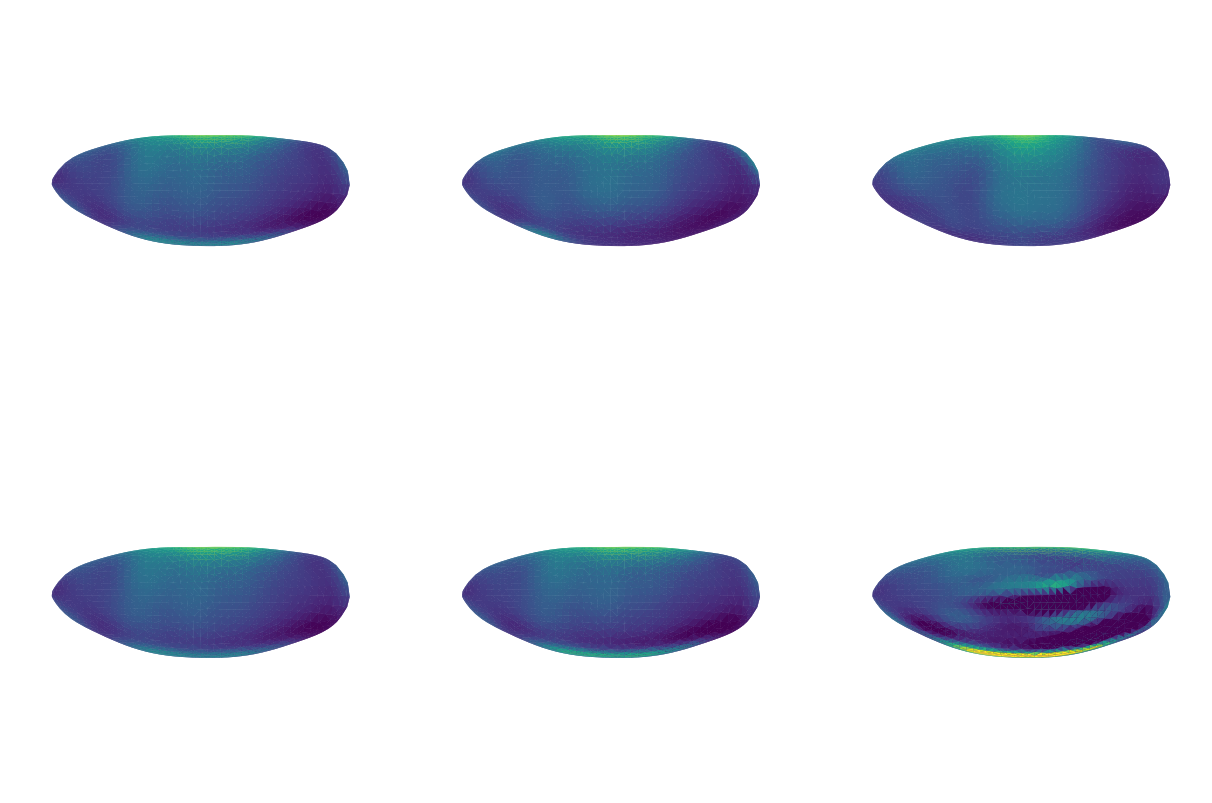

In [23]:
from utils.geometry.plot_utils import *
from utils.geometry.geometry_utils import TangentSpaceTransformer
from sklearn.pipeline import Pipeline
fig, ax = plt.subplots(2, 3, dpi=250, subplot_kw=dict(projection='3d'))

vmin, vmax = np.min(s0), np.max(s0)
pipe = Pipeline([
    ('mesh', MeshInterpolator()),
    ('tangent', TangentSpaceTransformer()),
]).fit(s0)
    
print(s0.shape, s.shape)
    
for i in range(3):
    color_3D(ax[0, i], pipe.transform(s0[i*10]), vmin=vmin, vmax=vmax)
    color_3D(ax[1, i], pipe.transform(s[i*10, 0]), vmin=vmin, vmax=vmax)

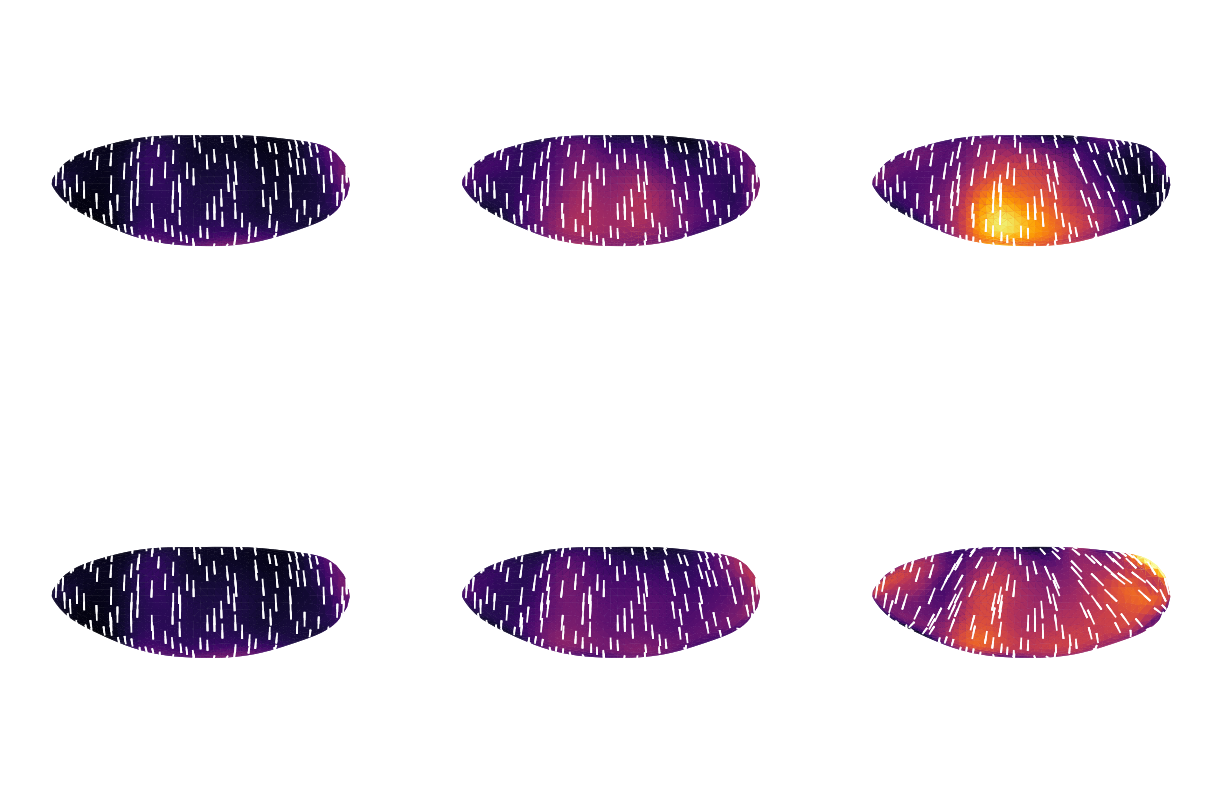

In [4]:
from utils.geometry.plot_utils import *
from utils.geometry.geometry_utils import TangentSpaceTransformer
from sklearn.pipeline import Pipeline
fig, ax = plt.subplots(2, 3, dpi=250, subplot_kw=dict(projection='3d'))

mnorm = np.linalg.norm(m0, axis=(1, 2))
vmin, vmax = np.min(mnorm), np.max(mnorm)
ts = TangentSpaceTransformer().fit(None)
pipe = Pipeline([
    ('mesh', MeshInterpolator()),
    ('tangent', TangentSpaceTransformer()),
]).fit(mnorm)
    

for i in range(3):
    plot_tensor3D(ax[0, i], pipe.transform(m0[i*10]), vmin=vmin, vmax=vmax)
    plot_tensor3D(ax[1, i], pipe.transform(m[i*10].reshape([2, 2, 236, 200])), vmin=vmin, vmax=vmax)

In [5]:
from utils.geometry.geometry_utils import embryo_mesh

verts = embryo_mesh.coordinates()
pix_scale = 0.2619
verts = verts * pix_scale

ptp = np.ptp(verts, axis=0)
radius = np.mean(ptp[:2]/2)

print(f'3D Embryo: radius={radius:.3g}, circumference={2*np.pi*radius:.3g}, length={ptp[2]:.3g} (all in microns)')
print(f'2D Embryo: circumference={dv_max-dv_min:.3g}, length={ap_max-ap_min:.3g} (all in microns)')

3D Embryo: radius=86.7, circumference=545, length=455 (all in microns)
2D Embryo: circumference=534, length=452 (all in microns)
